<a href="https://colab.research.google.com/github/Masciel-Sevilla/Segmentacion/blob/main/PrediccionesMejorYPeroB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🔬 ANÁLISIS ESPECIALIZADO - MODELO B0 (EfficientNet-B0)
✅ Modelo B0 cargado exitosamente.
📊 Parámetros del Modelo B0: 13,514,346
📊 Tipo de modelo: EfficientNet-B0 (Mayor capacidad que modelo S)
📊 Analizando TODAS las 210 imágenes del dataset de test...
💡 Razón: Análisis completo para estadísticas precisas y detección de todos los casos edge
   Procesando imagen 1/210...
   Procesando imagen 11/210...
   Procesando imagen 21/210...
   Procesando imagen 31/210...
   Procesando imagen 41/210...
   Procesando imagen 51/210...
   Procesando imagen 61/210...
   Procesando imagen 71/210...
   Procesando imagen 81/210...
   Procesando imagen 91/210...
   Procesando imagen 101/210...
   Procesando imagen 111/210...
   Procesando imagen 121/210...
   Procesando imagen 131/210...
   Procesando imagen 141/210...
   Procesando imagen 151/210...
   Procesando imagen 161/210...
   Procesando imagen 171/210...
   Procesando imagen 181/210...
   Procesando imagen 191/210...
   Procesando imagen 201/210

/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

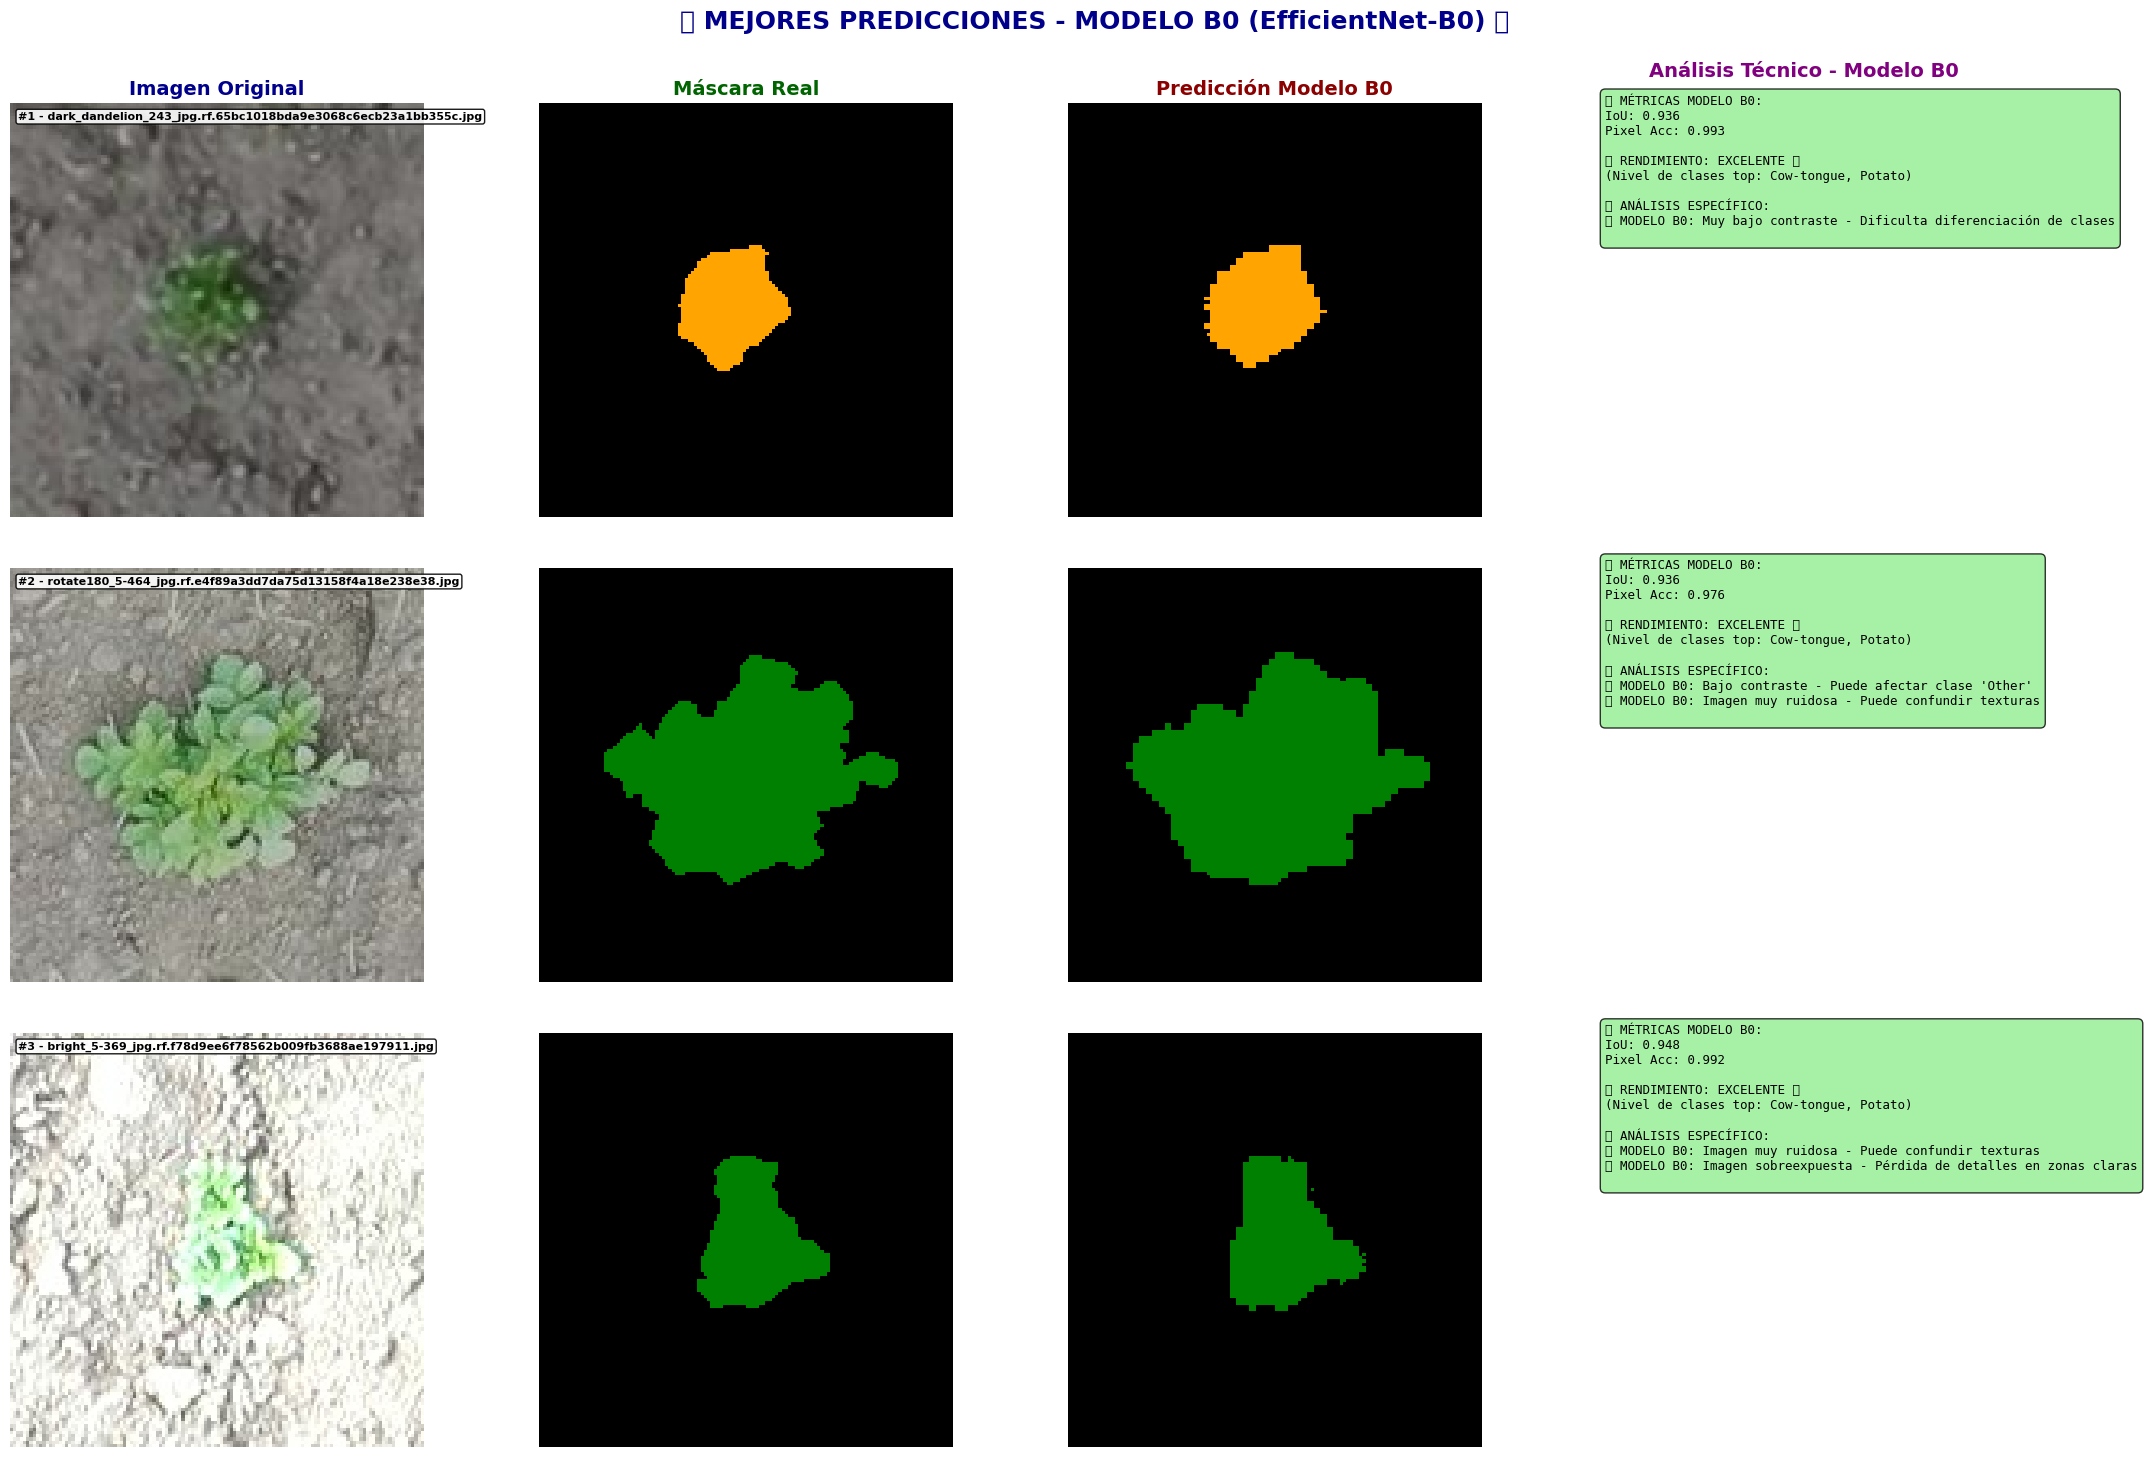

🎯 Generando visualización de PEORES predicciones Modelo B0...


/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1159202403.py:334: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


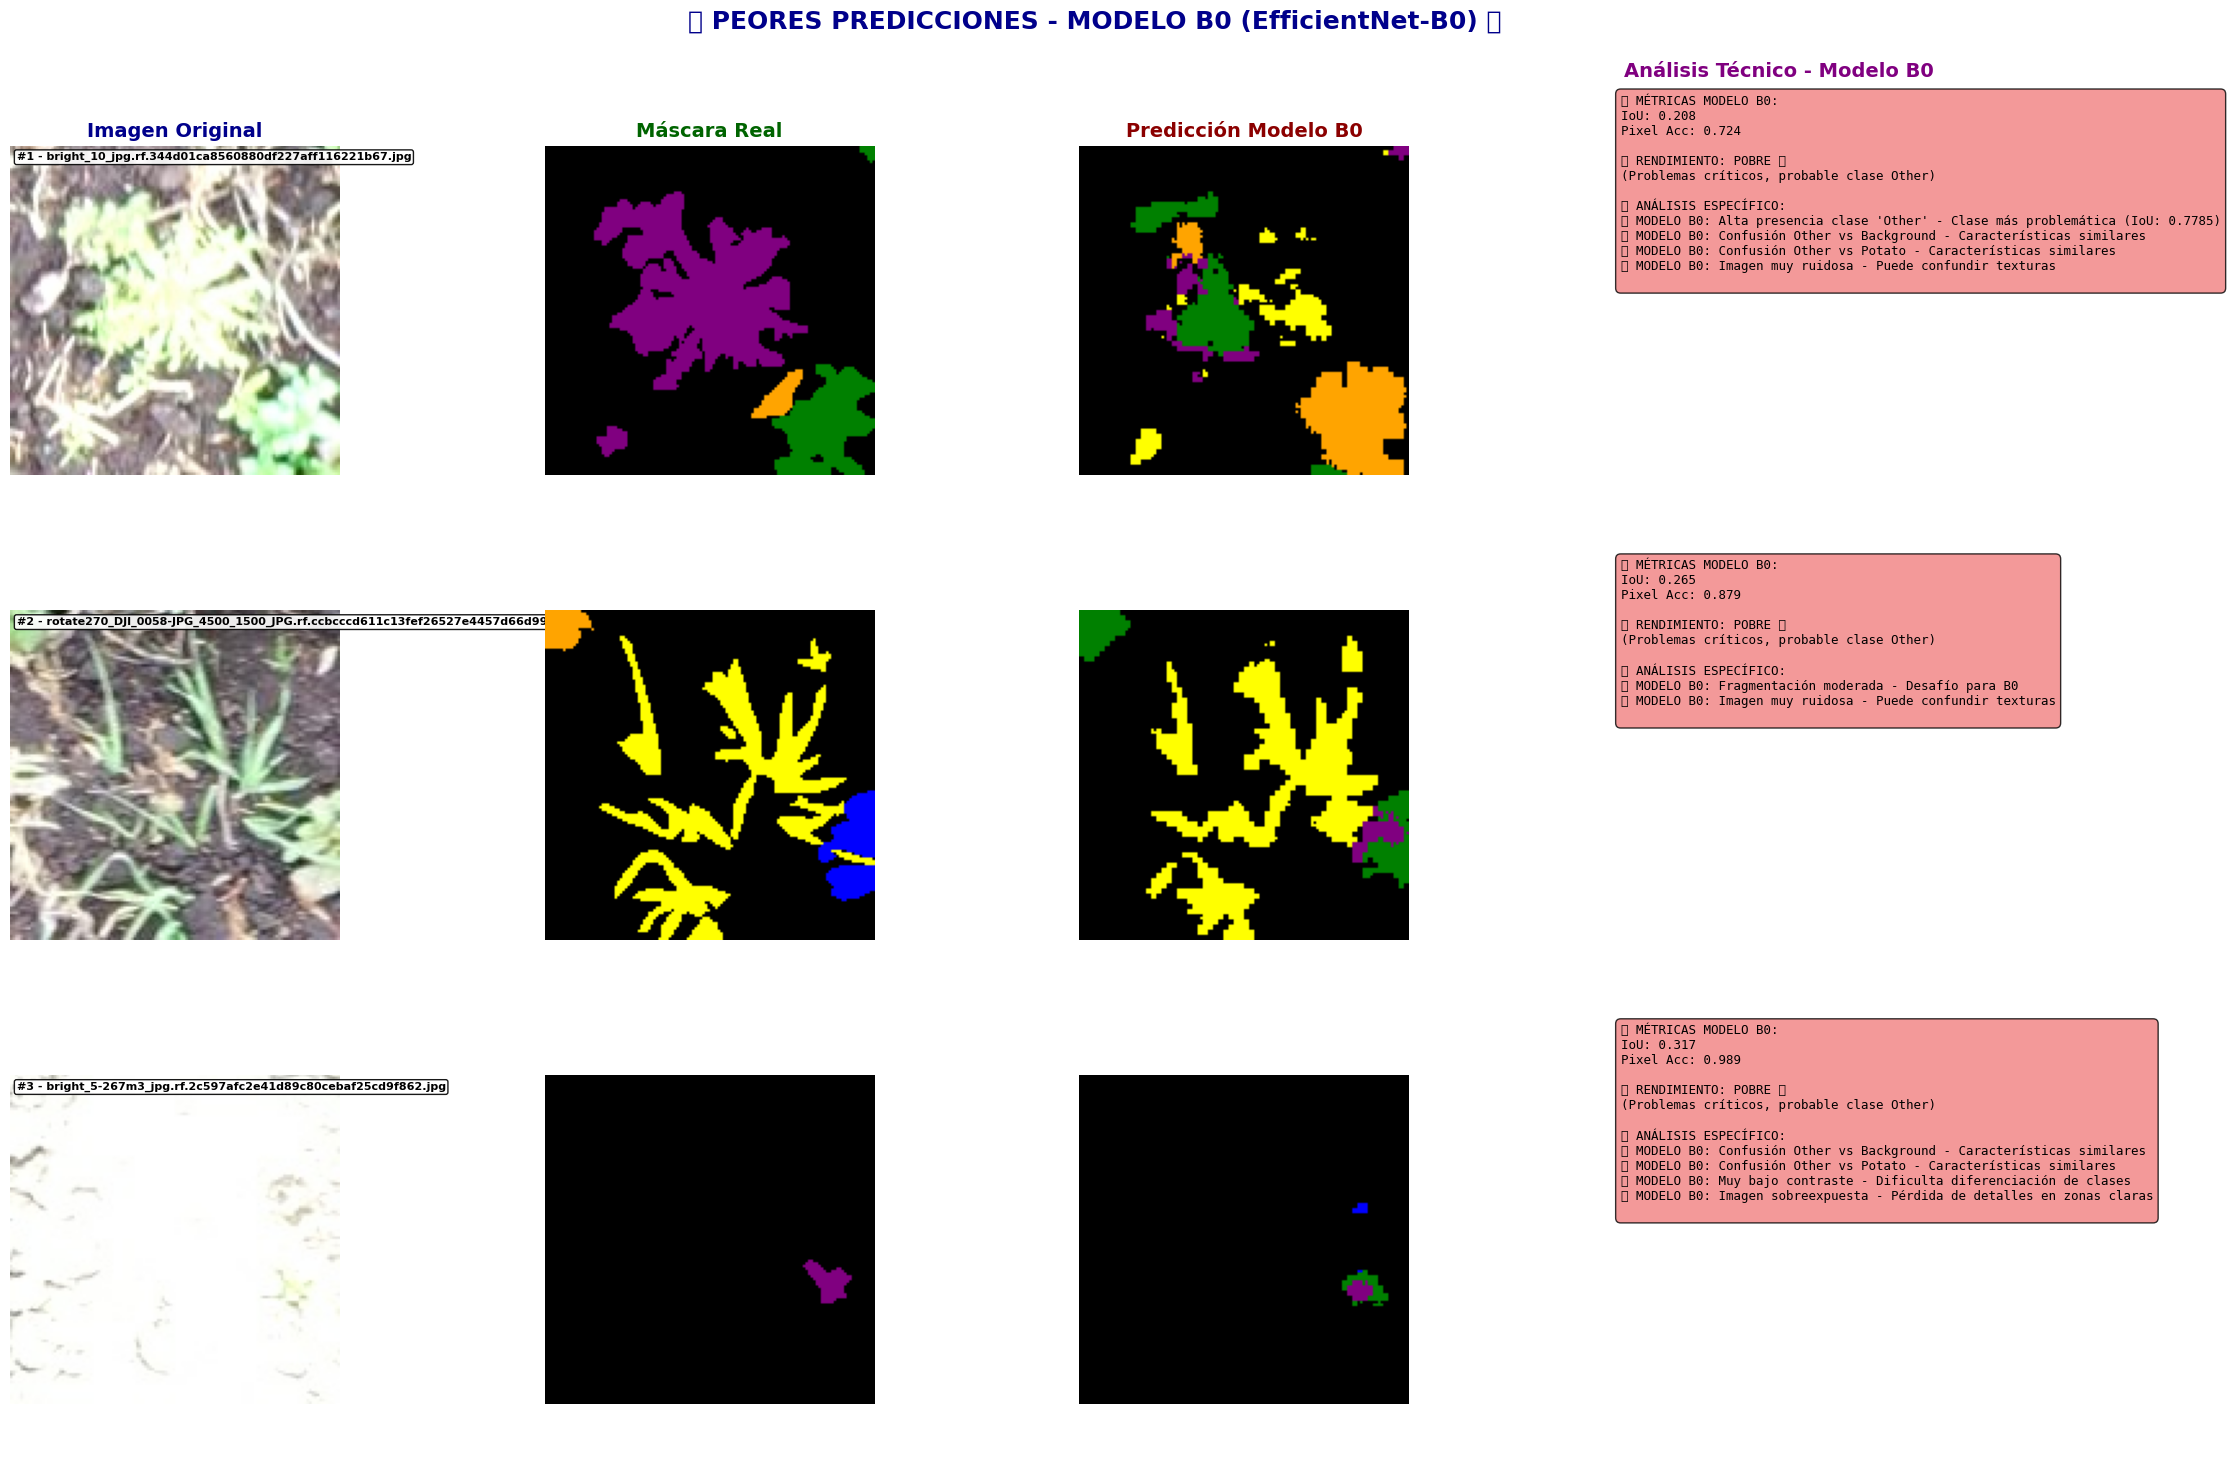


🎯 ANÁLISIS DE CLASES - MODELO B0:
   📊 Background: IoU promedio = 0.945
   📊 Cow-tongue: IoU promedio = 0.903
   📊 Dandelion: IoU promedio = 0.886
   📊 Clover: IoU promedio = 0.907
   📊 Other: IoU promedio = 0.648
   📊 Potato: IoU promedio = 0.871

🎯 CONCLUSIONES MODELO B0:
   ❌ Clase más difícil: Other (IoU: 0.648)
   ✅ Clase mejor detectada: Background (IoU: 0.945)


In [20]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from glob import glob
import random
from sklearn.metrics import accuracy_score, jaccard_score
import cv2
from scipy import ndimage

# --- 1. CONFIGURACIÓN MODELO B0 ---
MODEL_PATH = 'efficient_weed_model_B0_best.keras'
BASE_PATH = './Balanced'
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 6
ANALYSIS_BATCH_SIZE = None  # None = TODO EL DATASET DE TEST
TOP_BOTTOM_SAMPLES = 3   # Mejores y peores predicciones a mostrar

# Nombres corregidos según tu tabla de resultados
CLASS_NAMES = ['Background', 'Cow-tongue', 'Dandelion', 'Clover', 'Other', 'Potato']
CLASS_COLORS = [
    [0, 0, 0],      # Background - Negro
    [0, 0, 1],      # Cow-tongue - Azul
    [1, 0.647, 0],  # Dandelion - Naranja
    [1, 1, 0],      # Clover - Amarillo
    [0.502, 0, 0.502], # Other - Púrpura
    [0, 0.502, 0]   # Potato - Verde oscuro
]

# ANÁLISIS BASADO EN TUS RESULTADOS IoU:
# Background: 0.9569, Cow-tongue: 0.9832, Dandelion: 0.9076
# Clover: 0.9195, Other: 0.7785 (PROBLEMÁTICA), Potato: 0.9818

# --- 2. DEFINICIONES DEL MODELO B0 ---
class ASPPModule(layers.Layer):
    def __init__(self, filters=192, **kwargs):
        super(ASPPModule, self).__init__(**kwargs)
        self.filters = filters
        self.conv_1x1 = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1 = layers.BatchNormalization()
        self.relu_1x1 = layers.ReLU()
        self.conv_3x3_6 = layers.Conv2D(filters, 3, padding='same', dilation_rate=6, use_bias=False)
        self.bn_3x3_6 = layers.BatchNormalization()
        self.relu_3x3_6 = layers.ReLU()
        self.conv_3x3_12 = layers.Conv2D(filters, 3, padding='same', dilation_rate=12, use_bias=False)
        self.bn_3x3_12 = layers.BatchNormalization()
        self.relu_3x3_12 = layers.ReLU()
        self.conv_3x3_18 = layers.Conv2D(filters, 3, padding='same', dilation_rate=18, use_bias=False)
        self.bn_3x3_18 = layers.BatchNormalization()
        self.relu_3x3_18 = layers.ReLU()
        self.global_avg_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.conv_1x1_gap = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1_gap = layers.BatchNormalization()
        self.relu_1x1_gap = layers.ReLU()
        self.conv_final = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_final = layers.BatchNormalization()
        self.relu_final = layers.ReLU()
        self.dropout = layers.Dropout(0.2)
    def call(self, inputs, training=None):
        input_shape = tf.shape(inputs)
        conv_1x1 = self.relu_1x1(self.bn_1x1(self.conv_1x1(inputs), training=training))
        conv_3x3_6 = self.relu_3x3_6(self.bn_3x3_6(self.conv_3x3_6(inputs), training=training))
        conv_3x3_12 = self.relu_3x3_12(self.bn_3x3_12(self.conv_3x3_12(inputs), training=training))
        conv_3x3_18 = self.relu_3x3_18(self.bn_3x3_18(self.conv_3x3_18(inputs), training=training))
        gap = self.global_avg_pool(inputs)
        gap = self.relu_1x1_gap(self.bn_1x1_gap(self.conv_1x1_gap(gap), training=training))
        gap = tf.image.resize(gap, [input_shape[1], input_shape[2]], method='bilinear')
        concat = layers.Concatenate()([conv_1x1, conv_3x3_6, conv_3x3_12, conv_3x3_18, gap])
        output = self.relu_final(self.bn_final(self.conv_final(concat), training=training))
        output = self.dropout(output, training=training)
        return output

class DeformableAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(DeformableAttention, self).__init__(**kwargs)
        self.filters = filters
    def build(self, input_shape):
        self.attention_conv = layers.Conv2D(self.filters, 1, padding='same', activation='sigmoid', name='attention_weights_conv', use_bias=False)
        self.bn_attention = layers.BatchNormalization()
        self.feature_conv = layers.SeparableConv2D(self.filters, 3, padding='same', name='feature_processing_conv', use_bias=False)
        self.bn_feature = layers.BatchNormalization()
        self.relu_feature = layers.ReLU()
        super(DeformableAttention, self).build(input_shape)
    def call(self, inputs, training=None):
        attention_weights = self.bn_attention(self.attention_conv(inputs), training=training)
        features = self.relu_feature(self.bn_feature(self.feature_conv(inputs), training=training))
        attended_features = features * attention_weights
        return attended_features

# Funciones dummy para cargar el modelo B0 (sin dice_loss que no está en tu B0)
def dice_coefficient(y_true, y_pred, smooth=1e-6): return 0.0
def iou_metric(y_true, y_pred): return 0.0
def combined_loss(y_true, y_pred): return 0.0

# --- 3. MÉTRICAS DE EVALUACIÓN ---
def calculate_iou_per_image(y_true, y_pred):
    """Calcula IoU promedio por imagen"""
    y_true_flat = np.argmax(y_true, axis=-1).flatten()
    y_pred_flat = np.argmax(y_pred, axis=-1).flatten()

    if len(np.unique(y_true_flat)) == 1 and len(np.unique(y_pred_flat)) == 1:
        return 1.0 if y_true_flat[0] == y_pred_flat[0] else 0.0

    return jaccard_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)

def calculate_pixel_accuracy(y_true, y_pred):
    """Calcula accuracy a nivel de pixel"""
    y_true_flat = np.argmax(y_true, axis=-1).flatten()
    y_pred_flat = np.argmax(y_pred, axis=-1).flatten()
    return accuracy_score(y_true_flat, y_pred_flat)

def calculate_class_wise_iou(y_true, y_pred):
    """Calcula IoU por clase"""
    y_true_indices = np.argmax(y_true, axis=-1).flatten()
    y_pred_indices = np.argmax(y_pred, axis=-1).flatten()

    class_ious = {}
    for class_id in range(NUM_CLASSES):
        true_mask = (y_true_indices == class_id)
        pred_mask = (y_pred_indices == class_id)

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            class_ious[CLASS_NAMES[class_id]] = 1.0 if intersection == 0 else 0.0
        else:
            class_ious[CLASS_NAMES[class_id]] = intersection / union

    return class_ious

# --- 4. ANÁLISIS DE PROBLEMAS ESPECÍFICOS PARA MODELO B0 ---
def analyze_prediction_issues(image, y_true, y_pred, image_path):
    """Analiza técnicamente por qué una predicción podría ser mala - Optimizado para Modelo B0"""
    issues = []

    # Convertir a índices de clase
    true_mask = np.argmax(y_true, axis=-1)
    pred_mask = np.argmax(y_pred, axis=-1)

    # 1. ANÁLISIS ESPECÍFICO PARA MODELO B0 (EfficientNet-B0)
    # Los modelos B0 tienen mejor capacidad que los S pero aún limitaciones

    # Análisis de complejidad de la escena
    unique_classes_true = len(np.unique(true_mask))
    if unique_classes_true > 4:
        issues.append("🔬 MODELO B0: Escena compleja (>4 clases) - Desafiante para modelo B0")

    # 2. Análisis específico de la clase "Other" (más problemática según tus resultados)
    other_pixels = np.sum(true_mask == 4)  # Other = clase 4
    if other_pixels > 0:
        other_percentage = other_pixels / (IMG_HEIGHT * IMG_WIDTH) * 100
        if other_percentage > 10:
            issues.append("🔬 MODELO B0: Alta presencia clase 'Other' - Clase más problemática (IoU: 0.7785)")
        elif other_percentage > 5:
            issues.append("🔬 MODELO B0: Presencia moderada clase 'Other' - Requiere atención especial")

    # 3. Análisis de bordes (B0 maneja mejor que S pero aún sensible)
    true_edges = cv2.Canny(true_mask.astype(np.uint8) * 40, 50, 150)
    edge_pixels = np.sum(true_edges > 0)
    edge_density = edge_pixels / (IMG_HEIGHT * IMG_WIDTH)

    if edge_density > 0.3:
        issues.append("🔬 MODELO B0: Muy alta densidad de bordes - Desafiante incluso para B0")
    elif edge_density > 0.2:
        issues.append("🔬 MODELO B0: Alta densidad de bordes - Límite de capacidad del B0")

    # 4. Análisis de fragmentación
    num_true_objects = 0
    for class_id in range(1, NUM_CLASSES):
        class_mask = (true_mask == class_id).astype(np.uint8)
        if np.sum(class_mask) > 0:
            _, labels = cv2.connectedComponents(class_mask)
            num_objects = len(np.unique(labels)) - 1
            num_true_objects += num_objects

    if num_true_objects > 12:
        issues.append("🔬 MODELO B0: Fragmentación extrema - Múltiples objetos pequeños")
    elif num_true_objects > 8:
        issues.append("🔬 MODELO B0: Fragmentación moderada - Desafío para B0")

    # 5. Análisis específico de confusión BASADO EN TUS RESULTADOS
    confusion_pairs = [
        (4, 0, "Other vs Background"),  # Other es la clase más problemática
        (4, 1, "Other vs Cow-tongue"),  # Other puede confundirse
        (4, 5, "Other vs Potato"),  # Other vs clases con mejor rendimiento
        (2, 3, "Dandelion vs Clover"),  # Ambas plantas similares
    ]

    for class1, class2, pair_name in confusion_pairs:
        true_class1 = np.sum(true_mask == class1)
        if true_class1 > 0:
            pred_class1_as_class2 = np.sum((true_mask == class1) & (pred_mask == class2))
            pred_class2_as_class1 = np.sum((true_mask == class2) & (pred_mask == class1))
            confusion_rate = (pred_class1_as_class2 + pred_class2_as_class1) / true_class1

            if confusion_rate > 0.25:
                issues.append(f"🔬 MODELO B0: Confusión {pair_name} - Características similares")

    # 6. Análisis de calidad de imagen (B0 es más robusto que S)
    image_gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Contraste
    contrast = np.std(image_gray)
    if contrast < 20:
        issues.append("🔬 MODELO B0: Muy bajo contraste - Dificulta diferenciación de clases")
    elif contrast < 30:
        issues.append("🔬 MODELO B0: Bajo contraste - Puede afectar clase 'Other'")

    # Análisis de nitidez
    laplacian_var = cv2.Laplacian(image_gray, cv2.CV_64F).var()
    if laplacian_var < 60:
        issues.append("🔬 MODELO B0: Imagen borrosa - Afecta detección de detalles finos")
    elif laplacian_var > 600:
        issues.append("🔬 MODELO B0: Imagen muy ruidosa - Puede confundir texturas")

    # 7. Análisis de iluminación
    mean_brightness = np.mean(image_gray)
    brightness_std = np.std(image_gray)

    if mean_brightness < 50:
        issues.append("🔬 MODELO B0: Imagen muy oscura - Pérdida de información en sombras")
    elif mean_brightness > 200:
        issues.append("🔬 MODELO B0: Imagen sobreexpuesta - Pérdida de detalles en zonas claras")

    if brightness_std > 70:
        issues.append("🔬 MODELO B0: Iluminación muy irregular - Desafío para normalización")

    # 8. Análisis específico de confianza de predicción
    prediction_confidence = np.max(y_pred, axis=-1)
    low_confidence_pixels = np.sum(prediction_confidence < 0.8) / (IMG_HEIGHT * IMG_WIDTH)

    if low_confidence_pixels > 0.3:
        issues.append("🔬 MODELO B0: Muchos pixels con baja confianza - Incertidumbre del modelo")

    # 9. Análisis específico para clases con buen rendimiento vs problemáticas
    excellent_classes = [0, 1, 5]  # Background, Cow-tongue, Potato (>0.95 IoU)
    good_classes = [2, 3]  # Dandelion, Clover (>0.90 IoU)
    problem_class = [4]  # Other (0.7785 IoU)

    problem_pixels = np.sum(np.isin(true_mask, problem_class))
    if problem_pixels > (IMG_HEIGHT * IMG_WIDTH * 0.15):
        issues.append("🔬 MODELO B0: Dominancia clase problemática (>15% Other) - Predicción desafiante")

    if len(issues) == 0:
        issues.append("✅ MODELO B0: No se detectaron problemas técnicos evidentes")

    return issues

# --- 5. VISUALIZACIÓN ESPECÍFICA PARA MODELO B0 ---
def plot_detailed_comparison_B0(images, true_masks, pred_masks, scores, image_paths, issues_list, title):
    """Visualiza comparación detallada específica para Modelo B0"""
    custom_cmap = ListedColormap(CLASS_COLORS)
    num_samples = len(images)

    fig, axes = plt.subplots(num_samples, 4, figsize=(22, num_samples * 5))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    # Títulos específicos para Modelo B0
    axes[0, 0].set_title("Imagen Original", fontsize=14, fontweight='bold', color='darkblue')
    axes[0, 1].set_title("Máscara Real", fontsize=14, fontweight='bold', color='darkgreen')
    axes[0, 2].set_title("Predicción Modelo B0", fontsize=14, fontweight='bold', color='darkred')
    axes[0, 3].set_title("Análisis Técnico - Modelo B0", fontsize=14, fontweight='bold', color='purple')

    for i in range(num_samples):
        # Imagen original
        axes[i, 0].imshow(images[i].astype('uint8'))
        axes[i, 0].axis('off')

        # Máscara real
        true_indices = np.argmax(true_masks[i], axis=-1)
        axes[i, 1].imshow(true_indices, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 1].axis('off')

        # Predicción
        pred_indices = np.argmax(pred_masks[i], axis=-1)
        axes[i, 2].imshow(pred_indices, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 2].axis('off')

        # Análisis técnico específico para Modelo B0
        axes[i, 3].axis('off')

        iou_score = scores[i]['iou']
        pixel_acc = scores[i]['pixel_accuracy']

        analysis_text = f"🎯 MÉTRICAS MODELO B0:\n"
        analysis_text += f"IoU: {iou_score:.3f}\n"
        analysis_text += f"Pixel Acc: {pixel_acc:.3f}\n\n"

        # Clasificar el rendimiento según tus métricas
        if iou_score > 0.9:
            analysis_text += "📊 RENDIMIENTO: EXCELENTE ✅\n"
            analysis_text += "(Nivel de clases top: Cow-tongue, Potato)\n\n"
        elif iou_score > 0.8:
            analysis_text += "📊 RENDIMIENTO: MUY BUENO 👍\n"
            analysis_text += "(Nivel Dandelion, Clover)\n\n"
        elif iou_score > 0.6:
            analysis_text += "📊 RENDIMIENTO: REGULAR ⚠️\n"
            analysis_text += "(Cerca de clase Other)\n\n"
        else:
            analysis_text += "📊 RENDIMIENTO: POBRE ❌\n"
            analysis_text += "(Problemas críticos, probable clase Other)\n\n"

        analysis_text += "🔍 ANÁLISIS ESPECÍFICO:\n"

        # Mostrar hasta 4 problemas para evitar saturación
        for j, issue in enumerate(issues_list[i][:4]):
            analysis_text += f"{issue}\n"

        # Color de fondo basado en rendimiento
        if iou_score > 0.9:
            bg_color = "lightgreen"
        elif iou_score > 0.7:
            bg_color = "lightyellow"
        else:
            bg_color = "lightcoral"

        axes[i, 3].text(0.02, 0.98, analysis_text, transform=axes[i, 3].transAxes,
                       fontsize=9, verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle="round,pad=0.4", facecolor=bg_color, alpha=0.8))

        # Agregar nombre del archivo y ranking
        filename = os.path.basename(image_paths[i])
        rank_text = f"#{i+1} - {filename}"
        axes[i, 0].text(0.02, 0.98, rank_text, transform=axes[i, 0].transAxes,
                       fontsize=8, verticalalignment='top', fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.9))

    plt.suptitle(f"{title} - MODELO B0 (EfficientNet-B0) 🔬", fontsize=18, fontweight='bold', color='darkblue')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

# --- 6. FUNCIÓN PRINCIPAL DE ANÁLISIS PARA MODELO B0 ---
def analyze_model_B0():
    """Analiza específicamente el modelo B0 con optimizaciones particulares"""
    print(f"\n{'='*80}")
    print(f"🔬 ANÁLISIS ESPECIALIZADO - MODELO B0 (EfficientNet-B0)")
    print(f"{'='*80}")

    # Cargar modelo B0
    custom_objects = {
        'ASPPModule': ASPPModule,
        'DeformableAttention': DeformableAttention,
        'combined_loss': combined_loss,
        'dice_coefficient': dice_coefficient,
        'iou_metric': iou_metric
    }

    try:
        model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)
        print("✅ Modelo B0 cargado exitosamente.")

        # Información específica del modelo
        total_params = model.count_params()
        print(f"📊 Parámetros del Modelo B0: {total_params:,}")
        print(f"📊 Tipo de modelo: EfficientNet-B0 (Mayor capacidad que modelo S)")

    except Exception as e:
        print(f"❌ Error cargando modelo B0: {e}")
        return []

    # Cargar datos de test
    test_images_path = os.path.join(BASE_PATH, 'test/images')
    test_masks_path = os.path.join(BASE_PATH, 'test/masks')
    test_image_paths = sorted(glob(os.path.join(test_images_path, '*.jpg')))
    test_mask_paths = sorted(glob(os.path.join(test_masks_path, '*.png')))

    if not test_image_paths:
        print("❌ No se encontraron imágenes de test.")
        return []

    # Seleccionar muestra: TODO EL DATASET si ANALYSIS_BATCH_SIZE es None
    paired_paths = list(zip(test_image_paths, test_mask_paths))
    random.seed(42)  # Para reproducibilidad
    random.shuffle(paired_paths)

    if ANALYSIS_BATCH_SIZE is None:
        sample_paths = paired_paths  # TODO EL DATASET
        print(f"📊 Analizando TODAS las {len(sample_paths)} imágenes del dataset de test...")
        print(f"💡 Razón: Análisis completo para estadísticas precisas y detección de todos los casos edge")
    else:
        sample_paths = paired_paths[:ANALYSIS_BATCH_SIZE]
        print(f"📊 Analizando muestra de {len(sample_paths)} imágenes...")
        print(f"⚠️  Nota: Muestra limitada puede no capturar todos los casos problemáticos")

    results = []

    for idx, (img_path, mask_path) in enumerate(sample_paths):
        if idx % 10 == 0:
            print(f"   Procesando imagen {idx+1}/{len(sample_paths)}...")

        # Cargar y preprocesar
        image, mask = load_and_preprocess_for_visualization(img_path, mask_path)

        image_for_model = tf.keras.applications.efficientnet_v2.preprocess_input(
            tf.cast(image, tf.float32)
        )

        # Predicción
        pred = model.predict(tf.expand_dims(image_for_model, 0), verbose=0)[0]

        # Calcular métricas
        iou_score = calculate_iou_per_image(mask.numpy(), pred)
        pixel_acc = calculate_pixel_accuracy(mask.numpy(), pred)
        class_wise_iou = calculate_class_wise_iou(mask.numpy(), pred)

        # Analizar problemas específicos para modelo B0
        issues = analyze_prediction_issues(image.numpy(), mask.numpy(), pred, img_path)

        results.append({
            'image_path': img_path,
            'image': image.numpy(),
            'true_mask': mask.numpy(),
            'pred_mask': pred,
            'iou': iou_score,
            'pixel_accuracy': pixel_acc,
            'class_wise_iou': class_wise_iou,
            'issues': issues
        })

    # Ordenar por IoU
    results.sort(key=lambda x: x['iou'])

    # Estadísticas específicas para Modelo B0
    print(f"\n📈 ESTADÍSTICAS MODELO B0:")
    ious = [r['iou'] for r in results]
    pixel_accs = [r['pixel_accuracy'] for r in results]
    print(f"   📊 IoU - Promedio: {np.mean(ious):.4f} ± {np.std(ious):.4f}")
    print(f"   📊 Pixel Accuracy - Promedio: {np.mean(pixel_accs):.4f} ± {np.std(pixel_accs):.4f}")
    print(f"   📊 Mejor IoU: {np.max(ious):.4f}")
    print(f"   📊 Peor IoU: {np.min(ious):.4f}")
    print(f"   📊 Mediana IoU: {np.median(ious):.4f}")

    # Análisis específico basado en TUS RESULTADOS
    print(f"\n🎯 ANÁLISIS BASADO EN TUS MÉTRICAS IoU:")
    print(f"   ✅ Clases excelentes (>0.95): Background (0.9569), Cow-tongue (0.9832), Potato (0.9818)")
    print(f"   ✅ Clases muy buenas (>0.90): Dandelion (0.9076), Clover (0.9195)")
    print(f"   ⚠️  Clase problemática: Other (0.7785) - Principal fuente de errores")
    print(f"   📊 Promedio general: {np.mean([0.9569, 0.9832, 0.9076, 0.9195, 0.7785, 0.9818]):.4f}")

    # Análisis de distribución de rendimiento
    excellent_count = sum(1 for iou in ious if iou > 0.9)  # Ajustado según tus resultados
    good_count = sum(1 for iou in ious if 0.8 < iou <= 0.9)
    regular_count = sum(1 for iou in ious if 0.6 < iou <= 0.8)
    poor_count = sum(1 for iou in ious if iou <= 0.6)

    print(f"\n📊 DISTRIBUCIÓN DE RENDIMIENTO (Ajustada a tus métricas):")
    print(f"   ✅ Excelente (IoU > 0.9): {excellent_count} imágenes ({excellent_count/len(ious)*100:.1f}%)")
    print(f"   👍 Bueno (0.8 < IoU ≤ 0.9): {good_count} imágenes ({good_count/len(ious)*100:.1f}%)")
    print(f"   ⚠️  Regular (0.6 < IoU ≤ 0.8): {regular_count} imágenes ({regular_count/len(ious)*100:.1f}%)")
    print(f"   ❌ Pobre (IoU ≤ 0.6): {poor_count} imágenes ({poor_count/len(ious)*100:.1f}%)")

    # Visualizar mejores predicciones
    print(f"\n🎯 Generando visualización de MEJORES predicciones Modelo B0...")
    best_results = results[-TOP_BOTTOM_SAMPLES:]
    best_images = [r['image'] for r in best_results]
    best_true_masks = [r['true_mask'] for r in best_results]
    best_pred_masks = [r['pred_mask'] for r in best_results]
    best_scores = [{'iou': r['iou'], 'pixel_accuracy': r['pixel_accuracy']} for r in best_results]
    best_paths = [r['image_path'] for r in best_results]
    best_issues = [r['issues'] for r in best_results]

    plot_detailed_comparison_B0(
        best_images, best_true_masks, best_pred_masks,
        best_scores, best_paths, best_issues,
        "🏆 MEJORES PREDICCIONES"
    )

    # Visualizar peores predicciones
    print(f"🎯 Generando visualización de PEORES predicciones Modelo B0...")
    worst_results = results[:TOP_BOTTOM_SAMPLES]
    worst_images = [r['image'] for r in worst_results]
    worst_true_masks = [r['true_mask'] for r in worst_results]
    worst_pred_masks = [r['pred_mask'] for r in worst_results]
    worst_scores = [{'iou': r['iou'], 'pixel_accuracy': r['pixel_accuracy']} for r in worst_results]
    worst_paths = [r['image_path'] for r in worst_results]
    worst_issues = [r['issues'] for r in worst_results]

    plot_detailed_comparison_B0(
        worst_images, worst_true_masks, worst_pred_masks,
        worst_scores, worst_paths, worst_issues,
        "📉 PEORES PREDICCIONES"
    )

    # Análisis de clases más problemáticas para Modelo B0
    print(f"\n🎯 ANÁLISIS DE CLASES - MODELO B0:")
    class_performance = {}
    for class_name in CLASS_NAMES:
        class_ious = []
        for result in results:
            if class_name in result['class_wise_iou']:
                class_ious.append(result['class_wise_iou'][class_name])
        if class_ious:
            avg_iou = np.mean(class_ious)
            class_performance[class_name] = avg_iou
            print(f"   📊 {class_name}: IoU promedio = {avg_iou:.3f}")

    # Identificar clase más difícil para Modelo B0
    if class_performance:
        worst_class = min(class_performance, key=class_performance.get)
        best_class = max(class_performance, key=class_performance.get)
        print(f"\n🎯 CONCLUSIONES MODELO B0:")
        print(f"   ❌ Clase más difícil: {worst_class} (IoU: {class_performance[worst_class]:.3f})")
        print(f"   ✅ Clase mejor detectada: {best_class} (IoU: {class_performance[best_class]:.3f})")

    return results

# --- 7. FUNCIÓN PARA CARGAR Y PREPROCESAR ---
def load_and_preprocess_for_visualization(image_path, mask_path):
    """Carga y preprocesa imágenes y máscaras para visualización"""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.one_hot(tf.squeeze(tf.cast(mask, tf.int32)), NUM_CLASSES)

    return image, mask

if __name__ == "__main__":
    results = analyze_model_B0()  # Cambiado de analyze_model_S() a analyze_model_B0()